In [1]:
import brian2 as b2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import math
import params
import preprocessing
import connectivity
import random
import pickle

from input_factory import get_step_current, get_ou_current
from plot_tools import plot_voltage_and_current_traces

save_data = True

In [2]:
%%time
time = 1000 #ms
param_set_exc = params.param_set_exc
param_set_fs  = params.param_set_fs
param_set_nfs = params.param_set_nfs

# reversal potential for COBA synapses
E_exc = 0 * b2.mV
E_inh = -80 * b2.mV

CPU times: user 92 µs, sys: 1e+03 ns, total: 93 µs
Wall time: 97 µs


In [3]:
dir = "two_layers_coba"
run_counter = '2' #'1' for L4 only

if save_data:
    if not os.path.exists('result_' + dir):
            os.makedirs('result_' + dir)
            
    saving_dir='result_' + dir+'/'+str(run_counter)+'/'
    if not os.path.exists(saving_dir):
            os.makedirs(saving_dir)



# 2 --> exc neuron

model_eqs_1 = '''
dv/dt = (-gL_1*(v-v_rest_1) - w1 - w2 + I)/C_1 : volt

dw1/dt = -w1/tau_w1_1 : amp
dw2/dt = -w2/tau_w2_1 : amp

dvt1/dt = -vt1/tau_vt1_1 : volt
dvt2/dt = -vt2/tau_vt2_1 : volt

vt = v_thresh_1 + vt1 + vt2 : volt
lambda_t = lambda_0_1*exp((v-vt)/del_v_1): Hz

I = I_syn + Iexc_ext(t,i) : amp
I_syn = I_exc + I_inh + I_noise : amp
I_noise = -g_noise*(v-E_exc) : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_noise/dt = -g_noise/tau_exc_1 : siemens
dg_exc/dt = -g_exc/tau_exc_1: siemens
dg_inh/dt = -g_inh/tau_inh_1 : siemens
'''
reset_eqs_1 = '''
v = v_reset_1
w1+=amp_w1_1
w2+=amp_w2_1
vt1+=amp_vt1_1
vt2+=amp_vt2_1
'''

exc_df = pd.read_csv('data/exc.txt',header = None)
exc_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


exc_param = exc_df.iloc[param_set_exc,:] #set which value to try out, set any if running through all

lambda_0_1 = 10 * b2.kHz

C_1 = exc_param['C (nF)'] * b2.nF
gL_1 = exc_param['gL (usiemens)'] * b2.usiemens
v_rest_1 = exc_param['v_rest (mV)'] * b2.mV
v_reset_1 = exc_param['v_reset (mV)'] * b2.mV
tau_refr_1 = exc_param['tau_refr (ms)'] * b2.ms

v_thresh_1 = exc_param['v_thresh (mV)'] * b2.mV
del_v_1 = exc_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_1 = exc_param['amp_w1 (nA)'] * b2.nA
tau_w1_1 = exc_param['tau_w1 (ms)'] * b2.ms
amp_w2_1 = exc_param['amp_w2 (nA)'] * b2.nA
tau_w2_1 = exc_param['tau_w2 (ms)'] * b2.ms

amp_vt1_1 = exc_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_1 = exc_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_1 = exc_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_1 = exc_param['tau_vt2 (ms)'] * b2.ms

tau_exc_1 = params.conn_param['L23_L23']['exc_exc']['tau_syn'] * b2.ms
tau_inh_1 = params.conn_param['L23_L23']['fs_exc']['tau_syn'] * b2.ms



## 2 --> fs neuron
model_eqs_2 = '''
dv/dt = (-gL_2*(v-v_rest_2) - w1 - w2 + I)/C_2 : volt

dw1/dt = -w1/tau_w1_2 : amp
dw2/dt = -w2/tau_w2_2 : amp

dvt1/dt = -vt1/tau_vt1_2 : volt
dvt2/dt = -vt2/tau_vt2_2 : volt

vt = v_thresh_2 + vt1 + vt2 : volt
lambda_t = lambda_0_2*exp((v-vt)/del_v_2): Hz

I = I_syn + Ifs_ext(t,i) : amp
I_syn = I_exc + I_inh + I_noise : amp
I_noise = -g_noise*(v-E_exc) : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_noise/dt = -g_noise/tau_exc_2 : siemens
dg_exc/dt = -g_exc/tau_exc_2: siemens
dg_inh/dt = -g_inh/tau_inh_2 : siemens
'''
reset_eqs_2 = '''
v = v_reset_2
w1+=amp_w1_2
w2+=amp_w2_2
vt1+=amp_vt1_2
vt2+=amp_vt2_2
'''

fs_df = pd.read_csv('data/fs.txt',header = None)
fs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


fs_param = fs_df.iloc[param_set_fs,:] #set which value to try out, set any if running through all

lambda_0_2 = 10 * b2.kHz

C_2 = fs_param['C (nF)'] * b2.nF
gL_2 = fs_param['gL (usiemens)'] * b2.usiemens
v_rest_2 = fs_param['v_rest (mV)'] * b2.mV
v_reset_2 = fs_param['v_reset (mV)'] * b2.mV
tau_refr_2 = fs_param['tau_refr (ms)'] * b2.ms

v_thresh_2 = fs_param['v_thresh (mV)'] * b2.mV
del_v_2 = fs_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_2 = fs_param['amp_w1 (nA)'] * b2.nA
tau_w1_2 = fs_param['tau_w1 (ms)'] * b2.ms
amp_w2_2 = fs_param['amp_w2 (nA)'] * b2.nA
tau_w2_2 = fs_param['tau_w2 (ms)'] * b2.ms

amp_vt1_2 = fs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_2 = fs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_2 = fs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_2 = fs_param['tau_vt2 (ms)'] * b2.ms

tau_exc_2 = params.conn_param['L23_L23']['exc_fs']['tau_syn'] * b2.ms
tau_inh_2 = params.conn_param['L23_L23']['fs_fs']['tau_syn'] * b2.ms


# 3 --> nfs neuron
model_eqs_3 = '''
dv/dt = (-gL_3*(v-v_rest_3) - w1 - w2 + I)/C_3 : volt

dw1/dt = -w1/tau_w1_3 : amp
dw2/dt = -w2/tau_w2_3 : amp

dvt1/dt = -vt1/tau_vt1_3 : volt
dvt2/dt = -vt2/tau_vt2_3 : volt

vt = v_thresh_3 + vt1 + vt2 : volt
lambda_t = lambda_0_3*exp((v-vt)/del_v_3): Hz

I = I_syn + Infs_ext(t,i) : amp
I_syn = I_exc + I_inh + I_noise : amp
I_noise = -g_noise*(v-E_exc) : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_noise/dt = -g_noise/tau_exc_3 : siemens
dg_exc/dt = -g_exc/tau_exc_3: siemens
dg_inh/dt = -g_inh/tau_inh_3 : siemens
'''
reset_eqs_3 = '''
v = v_reset_3
w1+=amp_w1_3
w2+=amp_w2_3
vt1+=amp_vt1_3
vt2+=amp_vt2_3
'''

nfs_df = pd.read_csv('data/nfs.txt',header = None)
nfs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


nfs_param = nfs_df.iloc[param_set_nfs,:] #set which value to try out, set any if running through all

lambda_0_3 = 10 * b2.kHz

C_3 = nfs_param['C (nF)'] * b2.nF
gL_3 = nfs_param['gL (usiemens)'] * b2.usiemens
v_rest_3 = nfs_param['v_rest (mV)'] * b2.mV
v_reset_3 = nfs_param['v_reset (mV)'] * b2.mV
tau_refr_3 = nfs_param['tau_refr (ms)'] * b2.ms

v_thresh_3 = nfs_param['v_thresh (mV)'] * b2.mV
del_v_3 = nfs_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_3 = nfs_param['amp_w1 (nA)'] * b2.nA
tau_w1_3 = nfs_param['tau_w1 (ms)'] * b2.ms
amp_w2_3 = nfs_param['amp_w2 (nA)'] * b2.nA
tau_w2_3 = nfs_param['tau_w2 (ms)'] * b2.ms

amp_vt1_3 = nfs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_3 = nfs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_3 = nfs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_3 = nfs_param['tau_vt2 (ms)'] * b2.ms

tau_exc_3 = params.conn_param['L23_L23']['exc_nfs']['tau_syn'] * b2.ms
tau_inh_3 = params.conn_param['L23_L23']['nfs_nfs']['tau_syn'] * b2.ms

#####
I_newexc = np.loadtxt('Iexc.txt') * b2.namp
Iexc_ext = b2.TimedArray(I_newexc, dt = 1.*b2.ms)

I_newfs = np.loadtxt('Ifs.txt') * b2.namp
Ifs_ext = b2.TimedArray(I_newfs, dt = 1.*b2.ms)

I_newnfs = np.loadtxt('Infs.txt') * b2.namp
Infs_ext = b2.TimedArray(I_newnfs, dt = 1.*b2.ms)

####

################ forming populations #############

pops = {}

pops['L23exc'] = b2.NeuronGroup(params.size['L23']['exc'],model=model_eqs_1, reset = reset_eqs_1, threshold = "v > vt", refractory = tau_refr_1, method = 'rk4')
pops['L23fs'] = b2.NeuronGroup(params.size['L23']['fs'],model=model_eqs_2, reset = reset_eqs_2, threshold = "v > vt", refractory = tau_refr_2, method = 'rk4')
pops['L23nfs'] = b2.NeuronGroup(params.size['L23']['nfs'],model=model_eqs_3, reset = reset_eqs_3, threshold = "v > vt", refractory = tau_refr_3, method = 'rk4')


pops['L4exc'] = b2.NeuronGroup(params.size['L4']['exc'],model=model_eqs_1, reset = reset_eqs_1, threshold = "v > vt", refractory = tau_refr_1, method = 'rk4')
pops['L4fs'] = b2.NeuronGroup(params.size['L4']['fs'],model=model_eqs_2, reset = reset_eqs_2, threshold = "v > vt", refractory = tau_refr_2, method = 'rk4')
pops['L4nfs'] = b2.NeuronGroup(params.size['L4']['nfs'],model=model_eqs_3, reset = reset_eqs_3, threshold = "v > vt", refractory = tau_refr_3, method = 'rk4')

## add thalamus
# thalamus = b2.PoissonGroup(600, rates = '(1+sin(t*5*Hz))*7*Hz')

####################################################


################# forming synapses ###################

# inside L4 #

conn_L4exc_L4exc = b2.Synapses(pops['L4exc'], pops['L4exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4exc.connect(p = params.conn_param['L4_L4']['exc_exc']['p'])
conn_L4exc_L4exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L4fs_L4fs = b2.Synapses(pops['L4fs'], pops['L4fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4fs_L4fs.connect(p = params.conn_param['L4_L4']['fs_fs']['p'])
conn_L4fs_L4fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['fs_fs']['w']*b2.nA, v_rest_2, E_inh)

conn_L4exc_L4fs = b2.Synapses(pops['L4exc'], pops['L4fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4fs.connect(p = params.conn_param['L4_L4']['exc_fs']['p'])
conn_L4exc_L4fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_fs']['w']*b2.nA, v_rest_2, E_exc)

conn_L4fs_L4exc = b2.Synapses(pops['L4fs'], pops['L4exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4fs_L4exc.connect(p = params.conn_param['L4_L4']['fs_exc']['p'])
conn_L4fs_L4exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['fs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L4exc_L4nfs = b2.Synapses(pops['L4exc'], pops['L4nfs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4nfs.connect(p = params.conn_param['L4_L4']['exc_nfs']['p'])
conn_L4exc_L4nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

conn_L4nfs_L4nfs = b2.Synapses(pops['L4nfs'], pops['L4nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4nfs.connect(p = params.conn_param['L4_L4']['nfs_nfs']['p'])
conn_L4nfs_L4nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L4nfs_L4exc = b2.Synapses(pops['L4nfs'], pops['L4exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4exc.connect(p = params.conn_param['L4_L4']['nfs_exc']['p'])
conn_L4nfs_L4exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L4nfs_L4fs = b2.Synapses(pops['L4nfs'], pops['L4fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4fs.connect(p = params.conn_param['L4_L4']['nfs_fs']['p'])
conn_L4nfs_L4fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_fs']['w']*b2.nA, v_rest_2, E_inh)

## inside L23
conn_L23exc_L23exc = b2.Synapses(pops['L23exc'], pops['L23exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23exc.connect(p = params.conn_param['L23_L23']['exc_exc']['p'])
conn_L23exc_L23exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L23exc_L23nfs = b2.Synapses(pops['L23exc'], pops['L23nfs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23nfs.connect(p = params.conn_param['L23_L23']['exc_nfs']['p'])
conn_L23exc_L23nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

conn_L23exc_L23fs = b2.Synapses(pops['L23exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23fs.connect(p = params.conn_param['L23_L23']['exc_fs']['p'])
conn_L23exc_L23fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_nfs']['w']*b2.nA, v_rest_2, E_exc)

conn_L23fs_L23exc = b2.Synapses(pops['L23fs'], pops['L23exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23exc.connect(p = params.conn_param['L23_L23']['fs_exc']['p'])
conn_L23fs_L23exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L23fs_L23nfs = b2.Synapses(pops['L23fs'], pops['L23nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23nfs.connect(p = params.conn_param['L23_L23']['fs_nfs']['p'])
conn_L23fs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L23fs_L23fs = b2.Synapses(pops['L23fs'], pops['L23fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23fs.connect(p = params.conn_param['L23_L23']['fs_exc']['p'])
conn_L23fs_L23fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_fs']['w']*b2.nA, v_rest_2, E_inh)

conn_L23nfs_L23exc = b2.Synapses(pops['L23nfs'], pops['L23exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23exc.connect(p = params.conn_param['L23_L23']['nfs_exc']['p'])
conn_L23nfs_L23exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L23nfs_L23nfs = b2.Synapses(pops['L23nfs'], pops['L23nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23nfs.connect(p = params.conn_param['L23_L23']['nfs_nfs']['p'])
conn_L23nfs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L23nfs_L23fs = b2.Synapses(pops['L23nfs'], pops['L23fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23fs.connect(p = params.conn_param['L23_L23']['nfs_fs']['p'])
conn_L23nfs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_fs']['w']*b2.nA, v_rest_2, E_inh)

## L4 to L23

conn_L4exc_L23exc = b2.Synapses(pops['L4exc'], pops['L23exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23exc.connect(p = params.conn_param['L4_L23']['exc_exc']['p'])
conn_L4exc_L23exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L4exc_L23fs = b2.Synapses(pops['L4exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23fs.connect(p = params.conn_param['L4_L23']['exc_fs']['p'])
conn_L4exc_L23fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_fs']['w']*b2.nA, v_rest_2, E_exc)

conn_L4exc_L23nfs = b2.Synapses(pops['L4exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23nfs.connect(p = params.conn_param['L4_L23']['exc_nfs']['p'])
conn_L4exc_L23nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

## thalamus!

# conn_th_L4exc = Connection(thalamus, pops['L4exc'], sparseness=0.2, weight = preprocessing.CUBA_to_COBA(0.024*nA, El_1, E_exc) , state='g_exc')  # w should be fixed
# conn_th_L4pv = Connection(thalamus, pops['L4pv'], sparseness=0.20, weight = preprocessing.CUBA_to_COBA(0.027*nA, El_2, E_exc), state='g_exc')  # w should be fixed

# conn_th_L23exc = Connection(thalamus, pops['L23exc'], sparseness=0.05, weight = preprocessing.CUBA_to_COBA(0.024*nA, El_1, E_exc), state='g_exc')  # w should be fixed
# conn_th_L23pv = Connection(thalamus, pops['L23pv'], sparseness=0.05, weight = preprocessing.CUBA_to_COBA(0.027*nA, El_2, E_exc), state='g_exc')  # w should be fixed

conn = {}
conn['L4exc_L4exc'] = conn_L4exc_L4exc
conn['L4exc_L4fs'] = conn_L4exc_L4fs
conn['L4exc_L4nfs'] = conn_L4exc_L4nfs
conn['L4fs_L4fs'] = conn_L4fs_L4fs
conn['L4fs_L4exc'] = conn_L4fs_L4exc
conn['L4nfs_L4exc'] = conn_L4nfs_L4exc
conn['L4nfs_L4fs'] = conn_L4nfs_L4fs
conn['L4nfs_L4nfs'] = conn_L4nfs_L4nfs

conn['L23exc_L23exc'] = conn_L23exc_L23exc
conn['L23exc_L23fs'] = conn_L23exc_L23fs
conn['L23exc_L23nfs'] = conn_L23exc_L23nfs
conn['L23fs_L23fs'] = conn_L23fs_L23fs
conn['L23fs_L23exc'] = conn_L23fs_L23exc
conn['L23fs_L23nfs'] = conn_L23fs_L23nfs
conn['L23nfs_L23exc'] = conn_L23nfs_L23exc
conn['L23nfs_L23fs'] = conn_L23nfs_L23fs
conn['L23nfs_L23nfs'] = conn_L23nfs_L23nfs

conn['L4exc_L23exc'] = conn_L4exc_L23exc
conn['L4_exc_L23fs'] = conn_L4exc_L23fs
conn['L4_exc_L23nfs'] = conn_L4exc_L23nfs
################## recorder ##########################

spikes = {}
rec_v = {}


spikes['L4exc'] = b2.SpikeMonitor(pops['L4exc'])
spikes['L4nfs'] = b2.SpikeMonitor(pops['L4nfs'])
spikes['L4fs'] = b2.SpikeMonitor(pops['L4fs'])
spikes['L23exc'] = b2.SpikeMonitor(pops['L23exc'])
spikes['L23nfs'] = b2.SpikeMonitor(pops['L23nfs'])
spikes['L23fs'] = b2.SpikeMonitor(pops['L23fs'])

rec_v['L4exc'] = b2.StateMonitor(pops['L4exc'], 'v', record = True)
rec_v['L4nfs'] = b2.StateMonitor(pops['L4nfs'], 'v', record = True)
rec_v['L4fs'] = b2.StateMonitor(pops['L4fs'], 'v', record = True)
rec_v['L23exc'] = b2.StateMonitor(pops['L23exc'], 'v', record = True)
rec_v['L23nfs'] = b2.StateMonitor(pops['L23nfs'], 'v', record = True)
rec_v['L23fs'] = b2.StateMonitor(pops['L23fs'], 'v', record = True)
################# running the simulation #############



# for i in random.sample(range(1,1656),200):
# 	pops['L4exc'][i:i+1].v = 0 * b2.mV

pops['L4exc'].v = exc_param['v_rest (mV)'] * b2.mV
pops['L4nfs'].v = nfs_param['v_rest (mV)'] * b2.mV
pops['L4fs'].v = fs_param['v_rest (mV)'] * b2.mV

pops['L23exc'].v = exc_param['v_rest (mV)'] * b2.mV
pops['L23nfs'].v = nfs_param['v_rest (mV)'] * b2.mV
pops['L23fs'].v = fs_param['v_rest (mV)'] * b2.mV

print("Before simulation" , datetime.datetime.now())
pops_net2 = b2.Network(pops,conn)
pops_net2.add(spikes, rec_v)
pops_net2.run(1000*b2.ms, report = 'text')
print("After simulation" , datetime.datetime.now())
os.system('say "finished"')
pops_net2.store('nospike')
print(params.size)

Before simulation 2018-07-26 17:05:03.173995
Starting simulation at t=0. s for a duration of 1. s
0.5706 s (57%) simulated in 10s, estimated 8s remaining.
1. s (100%) simulated in 17s
After simulation 2018-07-26 17:05:55.752625
{'L23': {'exc': 1691, 'nfs': 162, 'fs': 101}, 'L4': {'exc': 1656, 'nfs': 28, 'fs': 87}}


<IPython.core.display.Javascript object>


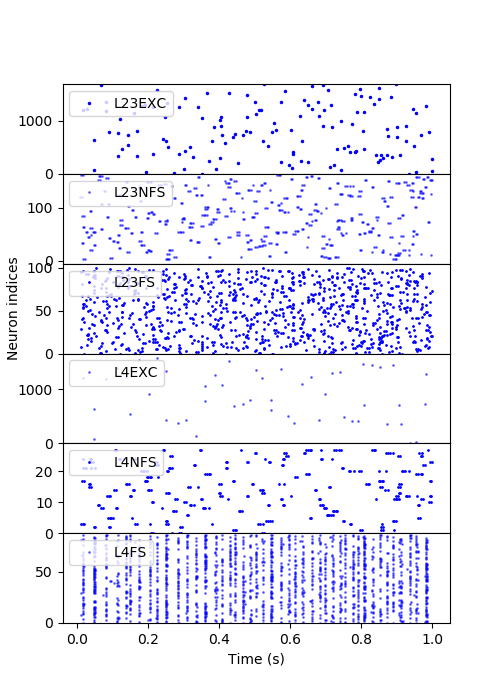

In [6]:
%matplotlib notebook
f, axarr = plt.subplots(6, sharex=True, sharey=False,figsize=(5,7))
axarr[0].plot(spikes['L23exc'].t, spikes['L23exc'].i,'o',markersize=1.5,color='b',alpha=1,label='L23EXC')
axarr[1].plot(spikes['L23nfs'].t, spikes['L23nfs'].i,'o',markersize=1,color='b',alpha=0.5,label='L23NFS')
axarr[2].plot(spikes['L23fs'].t, spikes['L23fs'].i,'o',markersize=1,color='b',alpha=1,label='L23FS')
axarr[3].plot(spikes['L4exc'].t, spikes['L4exc'].i,'o',markersize=1,color='b',alpha=0.5,label='L4EXC')
axarr[4].plot(spikes['L4nfs'].t, spikes['L4nfs'].i,'o',markersize=1,color='b',alpha=1,label='L4NFS')
axarr[5].plot(spikes['L4fs'].t, spikes['L4fs'].i,'o',markersize=1,color='b',alpha=0.5,label='L4FS')
axarr[5].set_xlabel('Time (s)')
axarr[2].set_ylabel('Neuron indices')

axarr[0].set_ylim(0,1692)
axarr[1].set_ylim(-5,163)
axarr[2].set_ylim(0,105)
axarr[3].set_ylim(0,1657)
axarr[4].set_ylim(0,29)
axarr[5].set_ylim(0,88)

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
axarr[1].ylim = 5
for ax in axarr:
    ax.label_outer()
    ax.legend(loc=2)

In [8]:
f.savefig('../figs/withsyn_1.jpg')

In [ ]:
pops_net2.restore('nospike')
# for i in np.random.randint(1500,size=1):
#     pops['L4exc'].v[i] = 0*b2.mV
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.subplot(231)
plt.plot(spikes['L23exc'].t, spikes['L23exc'].i,'o',markersize=1.5)
plt.subplot(232)
plt.plot(spikes['L23nfs'].t, spikes['L23nfs'].i,'o',markersize=1.5)
plt.subplot(233)
plt.plot(spikes['L23fs'].t, spikes['L23fs'].i,'o',markersize=1.5)
plt.subplot(234)
plt.plot(spikes['L4exc'].t, spikes['L4exc'].i,'o',markersize=1.5)
plt.subplot(235)
plt.plot(spikes['L4nfs'].t, spikes['L4nfs'].i,'o',markersize=1.5)
plt.subplot(236)
plt.plot(spikes['L4fs'].t, spikes['L4fs'].i,'o',markersize=1.5)


# fig2 = plt.figure()

# plt.subplot(111)
# plt.plot(rec_v['L4exc'].t/b2.ms, rec_v['L4exc'].v.T/b2.mV)

In [ ]:
pops_net2.restore('nospike')
for k in np.random.randint(1500,size=1):
    pops['L4exc'].v[k] = 0*b2.mV
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

In [ ]:
fig2 = plt.figure(figsize=(10,5))

plt.subplot(231)
plt.plot(spikes['L23exc'].t, spikes['L23exc'].i,'o',markersize=1.5)
plt.subplot(232)
plt.plot(spikes['L23nfs'].t, spikes['L23nfs'].i,'o',markersize=1.5)
plt.subplot(233)
plt.plot(spikes['L23fs'].t, spikes['L23fs'].i,'o',markersize=1.5)
plt.subplot(234)
plt.plot(spikes['L4exc'].t, spikes['L4exc'].i,'o',markersize=1.5)
plt.subplot(235)
plt.plot(spikes['L4nfs'].t, spikes['L4nfs'].i,'o',markersize=1.5)
plt.subplot(236)
plt.plot(spikes['L4fs'].t, spikes['L4fs'].i,'o',markersize=1.5)


# fig2 = plt.figure()

# plt.subplot(111)
# plt.plot(rec_v['L4exc'].t/b2.ms, rec_v['L4exc'].v.T/b2.mV)